 Dataset split created in: /kaggle/working/Malimg_split_moco
Classes: ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting MoCo Pretraining...
Epoch [1/20], MoCo Loss: 5.2126
Epoch [2/20], MoCo Loss: 5.5021
Epoch [3/20], MoCo Loss: 5.6162
Epoch [4/20], MoCo Loss: 5.4754
Epoch [5/20], MoCo Loss: 5.3299
Epoch [6/20], MoCo Loss: 5.2781
Early stopping triggered in pretraining!
Pretraining finished in 9.86 minutes
Extracting train features...
Extracting test features...
Training Random Forest...
Random Forest training finished in 8.47 seconds
Train Accuracy: 0.9564
Test Accuracy: 0.9154
Average Inference Time per Image: 0.15 ms

Classification Report:
                precision    recall  f1-score   support

     Adialer.C     1.0000    1.0000    1.0000        25
     Agent.FYI     0.8276    1.0000    0.9057        24
     Allaple.A     0.9671    0.8966    0.9305       590
     Allaple.L     0.9969    1.0000    0.9984       319
 Alueron.gen!J     0.6000    0.4500    0.5143        40
     Autorun.K     0.0000    0.0000    0.0000        22
       C2LOP.P     0.6875    0.7333    0.7097        30
   C2LOP.g

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 2000x2000 with 0 Axes>

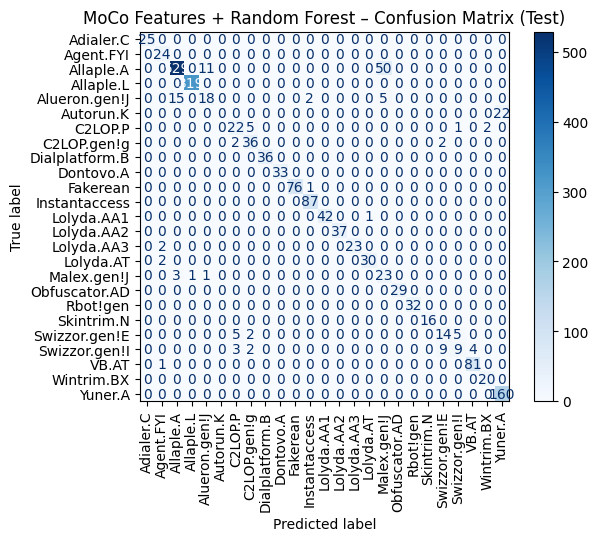

Class Adialer.C ROC-AUC: 1.0000
Class Agent.FYI ROC-AUC: 1.0000
Class Allaple.A ROC-AUC: 0.9962
Class Allaple.L ROC-AUC: 1.0000
Class Alueron.gen!J ROC-AUC: 0.9641
Class Autorun.K ROC-AUC: 0.9569
Class C2LOP.P ROC-AUC: 0.9936
Class C2LOP.gen!g ROC-AUC: 0.9977
Class Dialplatform.B ROC-AUC: 1.0000
Class Dontovo.A ROC-AUC: 1.0000
Class Fakerean ROC-AUC: 1.0000
Class Instantaccess ROC-AUC: 1.0000
Class Lolyda.AA1 ROC-AUC: 1.0000
Class Lolyda.AA2 ROC-AUC: 1.0000
Class Lolyda.AA3 ROC-AUC: 0.9765
Class Lolyda.AT ROC-AUC: 1.0000
Class Malex.gen!J ROC-AUC: 0.9847
Class Obfuscator.AD ROC-AUC: 1.0000
Class Rbot!gen ROC-AUC: 1.0000
Class Skintrim.N ROC-AUC: 1.0000
Class Swizzor.gen!E ROC-AUC: 0.9928
Class Swizzor.gen!I ROC-AUC: 0.9914
Class VB.AT ROC-AUC: 0.9997
Class Wintrim.BX ROC-AUC: 0.9999
Class Yuner.A ROC-AUC: 0.9936
Macro-average ROC-AUC: 0.9939


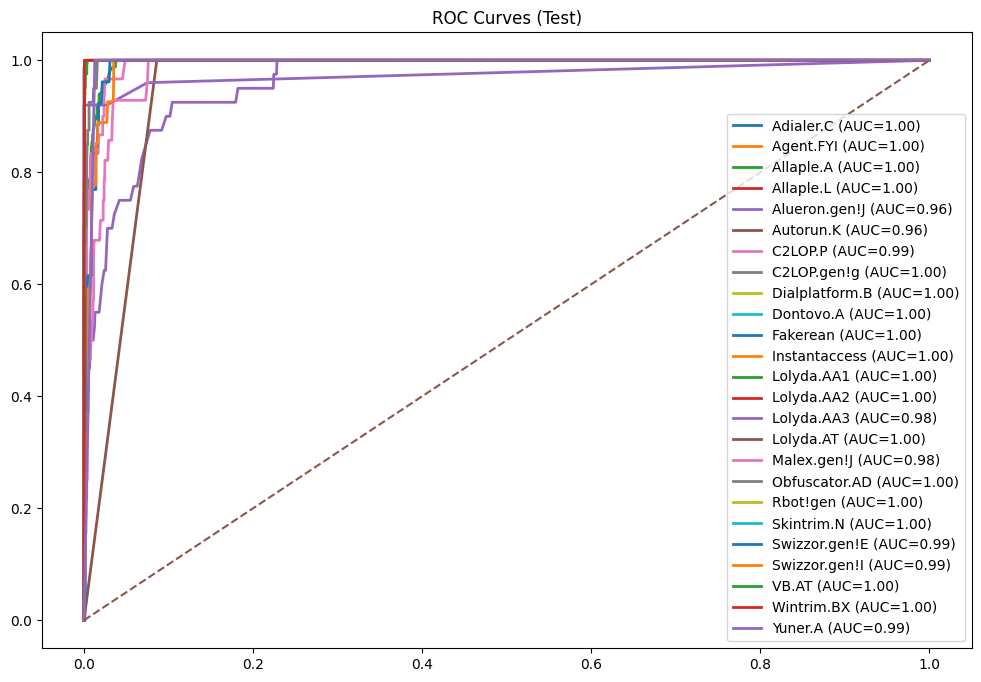

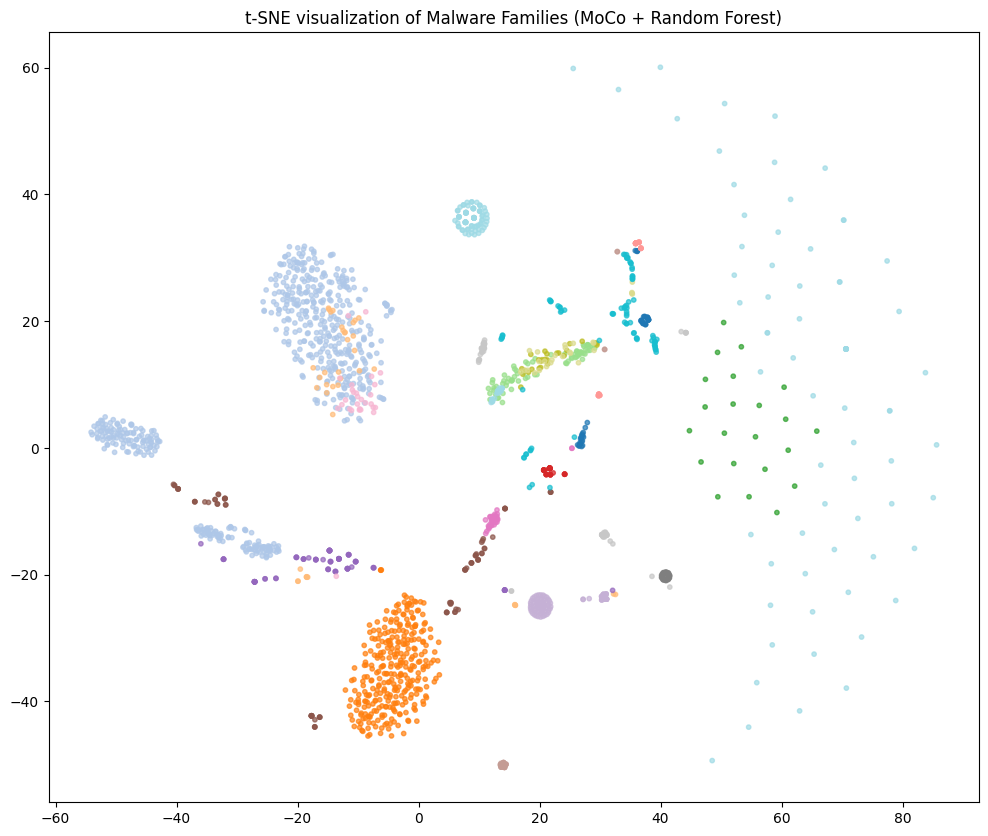

In [1]:
# ============================================
# MoCo (v2-style) Training + Eval on Malimg
# + Early Stopping, Timing, Classification Report
# ============================================

import os
import random
import shutil
import time
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image

# -----------------------------
# 0) Repro / Device
# -----------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True


# -----------------------------
# 1) Paths & Split (train/test only)
# -----------------------------
root_dir = "/kaggle/input/malimg"
working_dir = "/kaggle/working/Malimg_split_moco"

train_ratio, test_ratio = 0.8, 0.2
splits = ["train", "test"]
IMAGE_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

os.makedirs(working_dir, exist_ok=True)
for s in splits:
    os.makedirs(os.path.join(working_dir, s), exist_ok=True)

needs_split = any(len(os.listdir(os.path.join(working_dir, s))) == 0 for s in splits)

if needs_split:
    for cls in sorted(os.listdir(root_dir)):
        class_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(class_dir):
            continue

        images = [os.path.join(class_dir, f)
                  for f in os.listdir(class_dir)
                  if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(IMAGE_EXTS)]

        if len(images) == 0:
            images = [p for p in glob(os.path.join(class_dir, "**", "*"), recursive=True)
                      if os.path.isfile(p) and p.lower().endswith(IMAGE_EXTS)]

        if len(images) == 0:
            continue

        random.shuffle(images)
        n = len(images)
        n_train = int(n * train_ratio)

        assigns = {
            "train": images[:n_train],
            "test": images[n_train:]
        }

        for s in splits:
            dest_dir = os.path.join(working_dir, s, cls)
            os.makedirs(dest_dir, exist_ok=True)
            for src in assigns[s]:
                shutil.copy2(src, dest_dir)
    print(" Dataset split created in:", working_dir)
else:
    print(" Using existing split in:", working_dir)


# -----------------------------
# 2) Transforms
# -----------------------------
pretrain_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
])

clf_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])


# -----------------------------
# 3) Two-views dataset for MoCo
# -----------------------------
class ImageFolderTwoViews(ImageFolder):
    def __init__(self, root, base_transform):
        super().__init__(root, transform=None)
        self.base_transform = base_transform

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if isinstance(img, Image.Image) is False:
            img = Image.open(path).convert("RGB")
        im1 = self.base_transform(img)
        im2 = self.base_transform(img)
        return (im1, im2), target


# -----------------------------
# 4) Datasets & Loaders (with imbalance handling)
# -----------------------------
pretrain_dataset = ImageFolderTwoViews(
    os.path.join(working_dir, "train"), base_transform=pretrain_transform
)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=128, shuffle=True, drop_last=True)

train_dataset = ImageFolder(os.path.join(working_dir, "train"), transform=clf_transform)
test_dataset  = ImageFolder(os.path.join(working_dir, "test"),  transform=clf_transform)

# Weighted sampler for imbalance
targets = [label for _, label in train_dataset.samples]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)


# -----------------------------
# 5) MoCo (v2-style) Model
# -----------------------------
class ResNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        m = resnet18(pretrained=False)
        m.fc = nn.Identity()
        self.encoder = m
    def forward(self, x):
        return self.encoder(x)

class MLPHead(nn.Module):
    def __init__(self, in_dim=512, hidden=2048, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

class MoCo(nn.Module):
    def __init__(self, feature_dim=128, K=16384, m=0.99, T=0.07):
        super().__init__()
        self.K, self.m, self.T = K, m, T
        self.encoder_q = ResNetBackbone()
        self.encoder_k = ResNetBackbone()
        self.mlp_q = MLPHead()
        self.mlp_k = MLPHead()
        for p_q, p_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            p_k.data.copy_(p_q.data); p_k.requires_grad = False
        for p_q, p_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            p_k.data.copy_(p_q.data); p_k.requires_grad = False
        self.register_buffer("queue", torch.randn(feature_dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))
    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for p_q, p_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            p_k.data = p_k.data * self.m + p_q.data * (1. - self.m)
        for p_q, p_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            p_k.data = p_k.data * self.m + p_q.data * (1. - self.m)
    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]; ptr = int(self.queue_ptr); end = ptr + batch_size
        if end <= self.K:
            self.queue[:, ptr:end] = keys.T
        else:
            first_len = self.K - ptr
            self.queue[:, ptr:] = keys[:first_len].T
            self.queue[:, :end - self.K] = keys[first_len:].T
        self.queue_ptr[0] = (end) % self.K
    def forward(self, im_q, im_k):
        q_feat = self.encoder_q(im_q)
        q = nn.functional.normalize(self.mlp_q(q_feat), dim=1)
        with torch.no_grad():
            self._momentum_update_key_encoder()
            k_feat = self.encoder_k(im_k)
            k = nn.functional.normalize(self.mlp_k(k_feat), dim=1)
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])
        logits = torch.cat([l_pos, l_neg], dim=1) / self.T
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)
        with torch.no_grad(): self._dequeue_and_enqueue(k)
        return logits, labels


# -----------------------------
# 6) Pretrain MoCo (with Early Stopping + Timing)
# -----------------------------
moco = MoCo().to(device)
optimizer = optim.Adam(moco.parameters(), lr=1e-3)
epochs_ssl = 20
patience_ssl = 5
best_loss, wait = float("inf"), 0

print("Starting MoCo Pretraining...")
start_time = time.time()

moco.train()
for epoch in range(epochs_ssl):
    total_loss = 0.0
    for (im1, im2), _ in pretrain_loader:
        im_q, im_k = im1.to(device), im2.to(device)
        logits, labels = moco(im_q, im_k)
        loss = nn.CrossEntropyLoss()(logits, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(pretrain_loader)
    print(f"Epoch [{epoch+1}/{epochs_ssl}], MoCo Loss: {avg_loss:.4f}")
    # Early stopping check
    if avg_loss < best_loss:
        best_loss, wait = avg_loss, 0
        torch.save(moco.encoder_q.state_dict(), "moco_Malimg.pth")
    else:
        wait += 1
        if wait >= patience_ssl:
            print("Early stopping triggered in pretraining!")
            break

pretrain_time = time.time() - start_time
print(f"Pretraining finished in {pretrain_time/60:.2f} minutes")




from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import time

# -----------------------------
# 7) Feature Extraction for Random Forest
# -----------------------------
backbone = resnet18(pretrained=False)
backbone.fc = nn.Identity()
backbone.load_state_dict(torch.load("moco_Malimg.pth"), strict=False)
backbone = backbone.to(device)
backbone.eval()

def extract_features(dataloader, model):
    feats, labels = [], []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)   # shape (N, 512)
            feats.append(outputs.cpu().numpy())
            labels.extend(targets.numpy())
    return np.vstack(feats), np.array(labels)

print("Extracting train features...")
X_train, y_train = extract_features(train_loader, backbone)

print("Extracting test features...")
X_test, y_test = extract_features(test_loader, backbone)

# -----------------------------
# 8) Train Random Forest Classifier
# -----------------------------
print("Training Random Forest...")
start_time = time.time()
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf_clf.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"Random Forest training finished in {train_time:.2f} seconds")

# -----------------------------
# 9) Evaluation
# -----------------------------
# ---- Train Accuracy ----
train_pred = rf_clf.predict(X_train)
train_acc = (train_pred == y_train).mean()
print(f"Train Accuracy: {train_acc:.4f}")

# ---- Test Accuracy + Inference Time ----
start_infer = time.time()
y_pred = rf_clf.predict(X_test)
y_proba = rf_clf.predict_proba(X_test)
infer_time = time.time() - start_infer
avg_infer_time = infer_time / len(X_test)

test_acc = (y_pred == y_test).mean()
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Average Inference Time per Image: {avg_infer_time*1000:.2f} ms")

# ---- Classification Report ----
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=test_dataset.classes, digits=4))


# -----------------------------
# 10) Confusion Matrix + ROC-AUC + t-SNE
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20,20))
disp = ConfusionMatrixDisplay(cm, display_labels=test_dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90, values_format='d')
plt.title("MoCo Features + Random Forest – Confusion Matrix (Test)")
plt.show()

labels_onehot = label_binarize(y_test, classes=np.arange(num_classes))
roc_auc_per_class = roc_auc_score(labels_onehot, y_proba, average=None)
for i, cls in enumerate(test_dataset.classes):
    print(f"Class {cls} ROC-AUC: {roc_auc_per_class[i]:.4f}")
print(f"Macro-average ROC-AUC: {roc_auc_score(labels_onehot, y_proba, average='macro'):.4f}")

plt.figure(figsize=(12, 8))
for i, cls in enumerate(test_dataset.classes):
    fpr, tpr, _ = roc_curve(labels_onehot[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'--')
plt.legend(); plt.title("ROC Curves (Test)")
plt.show()

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeds = tsne.fit_transform(X_test)
plt.figure(figsize=(12,10))
plt.scatter(embeds[:,0], embeds[:,1], c=y_test, cmap="tab20", s=10, alpha=0.7)
plt.title("t-SNE visualization of Malware Families (MoCo + Random Forest)")
plt.show()
